In [277]:
#import modules
import math
import random
import numpy as np
from numpy.random import randint
from numpy import exp, pi
from numpy import linalg as LA
from numpy.fft import fft2, ifft2, fftshift
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc
rc('text', usetex=True)
import cv2
from PIL import Image
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import copy

#import files
import sys
sys.path.append('..')
from utils import matrix as mt
from utils import Likelihood
from utils import message_passing as mp
from utils import PtychoEP
from utils import ptycho
from utils import test
from utils import config
from utils import engines
from utils import error

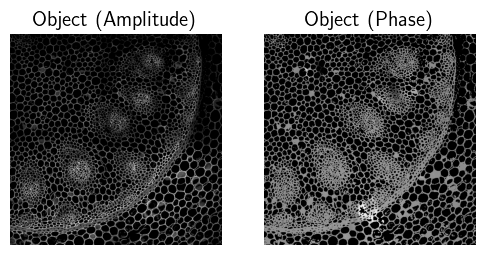

In [278]:
#load images (256 * 256 pixels)
path_obj_abs = "../data/lily.png"
path_obj_phase = "../data/moon.png"
obj = test.load_complex_image(path_obj_abs, path_obj_phase)
#obj = mt.complex_sparse_matrix(512, 0.4, 1)

#make round aperture (64 * 64 pixels)
aperture_x, aperture_y = np.meshgrid(np.linspace(-0.5, 0.5, num=64), np.linspace(-0.5, 0.5, num=64))
def Support(x, y):
    if x**2 + y**2 <= 0.5**2:
        return 1.
    else:
        return 0.
Pv = np.vectorize(Support)
aperture = Pv(aperture_x, aperture_y)
aperture = aperture + 1j * np.zeros_like(aperture) 

#showimages
test.show_complex_image(obj, "Object")

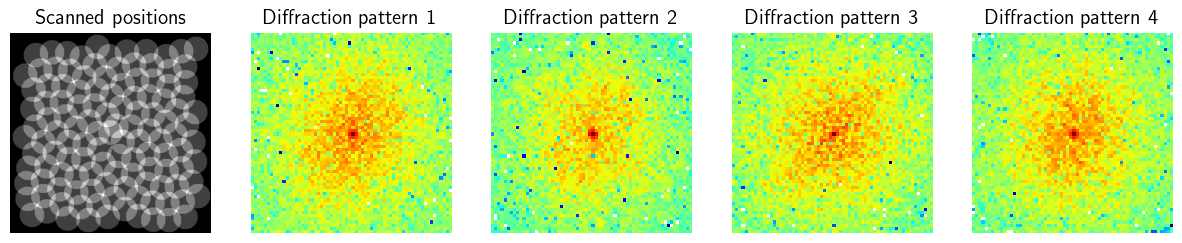

SNR =  30.156967179889605
Samping ratio =  2.3016511649861315
Number of scans =  125


In [292]:
np.random.seed(10)
scan_positions = []
c = 22.80
for i in range(1000):
    x, y = int(256 + c * np.sqrt(i) * np.cos(i*2.4))  , int(256 + c * np.sqrt(i) * np.sin(i*2.4))
    if x - 32 >= 0 and x + 32 <= 512:
        if y - 32 >= 0 and y + 32 <= 512:
            scan_positions.append([x,y])

#sorting
scan_positions = np.array(scan_positions)
distance = []
for i, scan_pos in enumerate(scan_positions):
    distance.append((256 - scan_pos[0])**2 + (256- scan_pos[1])**2)
distance = np.array(distance)
scan_positions = scan_positions[np.argsort(distance)]

noise = 0.00658

#create Ptycho object 
ptycho_data = ptycho.Ptycho(obj, aperture, scan_positions, noise)
ptycho_data.show()

#calculate SNR
total = 0
for diff in ptycho_data.diffs:
    total += np.mean(diff**2)
total /= len(scan_positions)
print("SNR = ",10 * np.log10(total/noise**2))
print("Samping ratio = ", ptycho_data.sampling_ratio)
print("Number of scans = ", len(ptycho_data.scan_pos))

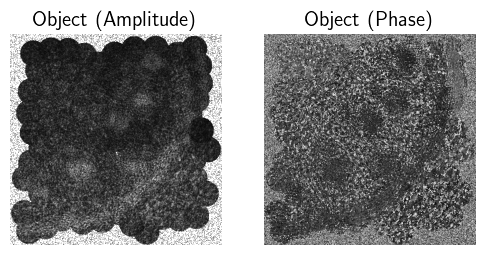

In [290]:
#make config
alpha = 0.1
object_init = mt.complex_gaussian_matrix(512, 1)
probe = ptycho_data.prb
num_iter = 400 #maximum iteration number
config_ePIE = config.config_PIE(alpha,  object_init, probe, num_iter)

#run PIE
obj_PIE, error_PIE = engines.PIE(ptycho_data, config_ePIE)

#show ePIE reconstruction
test.show_complex_image(obj_PIE, "Object")

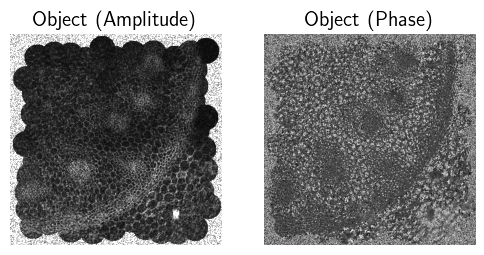

In [293]:
#make config
object_init = mt.complex_gaussian_matrix(512, 1)
probe = ptycho_data.prb
num_iter = 400
num_prb = None
damping = 0.95
config_PtychoEP = config.config_PtychoEP(object_init, probe, num_iter,num_prb, damping)

#run Ptychp-EP
obj_PtychoEP_Gaussian, gamma_PtychoEP_Gaussian, error_PtychoEP_Gaussian = PtychoEP.PtychoEP_Gaussian(ptycho_data, config_PtychoEP)

#show results
test.show_complex_image(obj_PtychoEP_Gaussian, "Object")

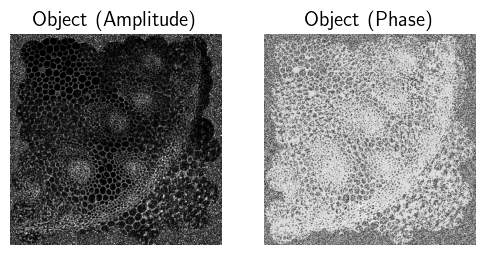

In [282]:
#make config
#object_init = np.ones_like(obj)
object_init = mt.complex_gaussian_matrix(512, 1)
probe = ptycho_data.prb
num_iter = 400
num_prb = None
damping = 0.95
rho = 0.4
config_PtychoEP_Sparse = config.config_PtychoEP_Sparse(object_init, probe, num_iter,num_prb, damping, rho)

#run Ptychp-EP with sparse prior
obj_PtychoEP_Sparse, gamma_PtychoEP_Sparse, error_PtychoEP_Sparse =  PtychoEP.PtychoEP_Sparse(ptycho_data, config_PtychoEP_Sparse)

#show results
test.show_complex_image(obj_PtychoEP_Sparse, "Object")

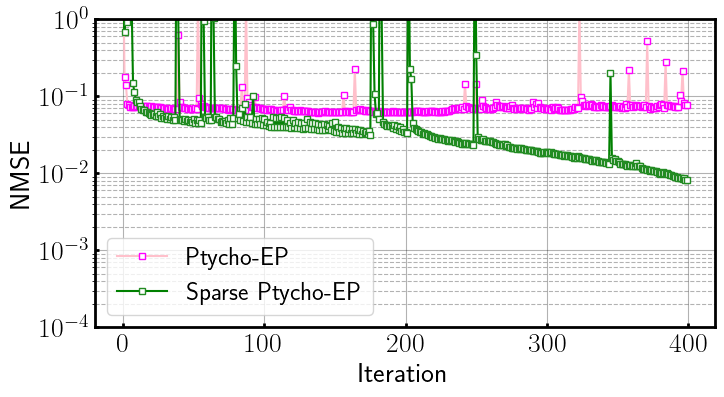

In [294]:
#show result
fig, ax = plt.subplots(1,1, figsize=(8, 4))
plt.tick_params(direction="in", length=3, width=2, labelsize=20)
ax.spines["right"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
#ax.plot(error_PIE/total, color = "blue", marker = "+", markeredgecolor = "navy", markerfacecolor = "white", markersize = 5, label = "PIE")
ax.plot(error_PtychoEP_Gaussian/total, color = "pink", marker = "s", markeredgecolor = "magenta", markerfacecolor = "white", markersize = 5, label = "Ptycho-EP")
ax.plot(error_PtychoEP_Sparse/total, color = "green", marker = "s", markeredgecolor = "forestgreen", markerfacecolor = "white", markersize = 5, label = "Sparse Ptycho-EP")
ax.set_xlabel("Iteration", fontsize = 20)
ax.set_ylabel("NMSE", fontsize = 20)
ax.set_ylim(1e-4, 1)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize = 18)
ax.grid(which='major',color='black',linestyle='-', alpha = 0.3)
ax.grid(which='minor',color='black',linestyle='--', alpha = 0.3)

1.0798996125409361

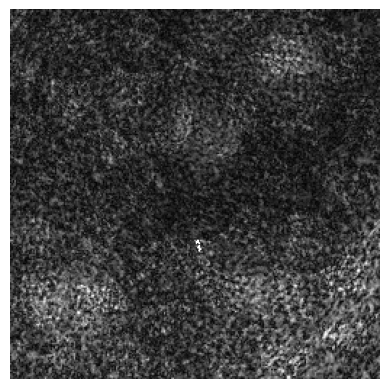

In [291]:
plt.imshow(np.abs(obj_PIE[128:383,128:383]), cmap = "gray", norm = Normalize(0,1))
plt.axis("off")
error.error_metric(obj[128:383,128:383], obj_PIE[128:383,128:383])

0.7023362359322748

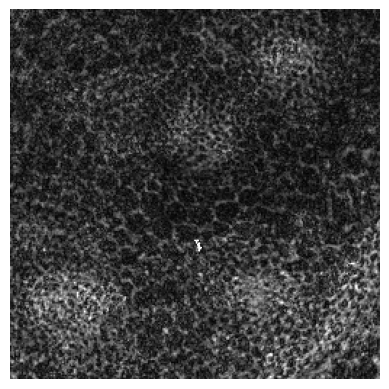

In [285]:
plt.imshow(np.abs(obj_PtychoEP_Gaussian[128:383,128:383]), cmap = "gray", norm = Normalize(vmin = 0, vmax = 1))
plt.axis("off")
error.error_metric(obj[128:383,128:383], obj_PtychoEP_Gaussian[128:383,128:383])

0.2853591860886543

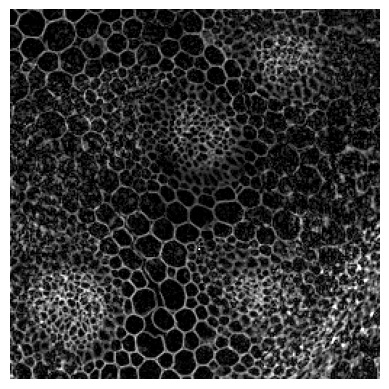

In [286]:
plt.imshow(np.abs(obj_PtychoEP_Sparse[128:383,128:383]), cmap = "gray", norm = Normalize(vmin = 0, vmax = 1))
plt.axis("off")
error.error_metric(obj[128:383,128:383], obj_PtychoEP_Sparse[128:383,128:383])

In [289]:
print(-10*np.log10(np.median([0.1284, 0.3542,0.1405,0.1393,0.03693,0.1635,0.1840,0.1240,0.03661,0.2853])))

8.541822855081723
